In [8]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
    
try:
    from functools import lru_cache
except ImportError:
    from backports.functools_lru_cache import lru_cache

%matplotlib inline

In [9]:
bands_to_use = ['red_630_690', 'nir1_780_900', 'green_530_610',
                'swir1_1550_1750', 'swir2_2090_2350', 'ndii']

In [10]:
in_file = '/g/data1/xc0/project/FMC_Australia/MCD43A4-collection-six/MCD43A4.A2017.h31v11.006.nc'
modis_band_map = {
    'band1': 'red_630_690',
    'band2': 'nir1_780_900',
    'band3': 'blue_450_520',
    'band4': 'green_530_610',
    'band5': 'nir2_1230_1250',
    'band6': 'swir1_1550_1750',
    'band7': 'swir2_2090_2350',
}
# From /g/data1/xc0/project/FMC_Australia/MCD43A4-collection-six/
ds = xr.open_dataset(in_file, chunks=dict(time=1, y=200, x=200))
ds.rename(modis_band_map, inplace=True)

ds['ndvi_ok_mask'] = 0.15 < (ds.nir1_780_900 - ds.red_630_690) / (ds.nir1_780_900 + ds.red_630_690)
# Note: I think this might have been calculated with nir1 and green in the original dataset!
ds['ndii'] = (ds.nir1_780_900 - ds.swir1_1550_1750) / (ds.nir1_780_900 + ds.swir1_1550_1750)

ds

/g/data1/xc0/software/conda-envs/rs2/lib/python2.7/site-packages/dask/array/core.py:2623: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


<xarray.Dataset>
Dimensions:          (time: 56, x: 2400, y: 2400)
Coordinates:
  * time             (time) datetime64[ns] 2017-01-01 2017-01-05 2017-01-09 ...
Dimensions without coordinates: x, y
Data variables:
    red_630_690      (time, y, x) float64 nan 0.1351 nan 0.131 0.1476 0.1363 ...
    nir1_780_900     (time, y, x) float64 nan 0.2509 nan 0.2314 0.2465 ...
    blue_450_520     (time, y, x) float64 nan 0.0459 nan 0.0469 0.0449 0.039 ...
    green_530_610    (time, y, x) float64 nan 0.092 nan 0.0936 0.0982 0.0837 ...
    nir2_1230_1250   (time, y, x) float64 nan 0.3198 nan 0.311 0.3209 0.3549 ...
    swir1_1550_1750  (time, y, x) float64 nan nan nan 0.3761 0.3904 0.3728 ...
    swir2_2090_2350  (time, y, x) float64 nan 0.2136 nan 0.2459 0.2629 ...
    ndvi_ok_mask     (time, y, x) bool False True False True True True True ...
    ndii             (time, y, x) float64 nan nan nan -0.2382 -0.2259 ...

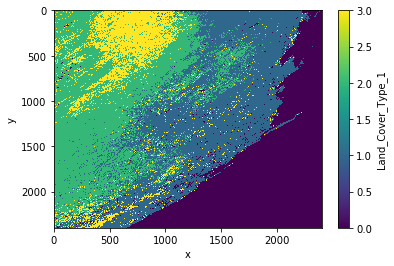

In [11]:
lc = xr.open_dataarray('/g/data/xc0/user/HatfieldDodds/FMC/landcover.2013.h31v11.nc')

# TODO: assert correctness w.r.t. array attribute names
shrub_mask = sum((lc == i) for i in (6, 7)).astype(bool)
grass_mask = sum((lc == i) for i in (10, 12)).astype(bool)
forest_mask = sum((lc == i) for i in (1, 2, 3, 4, 5, 8, 9)).astype(bool)

(forest_mask + 2 * shrub_mask + 3 * grass_mask).plot.imshow(yincrease=False)

In [12]:
merged_lookup = pd.read_csv('lookup_tables/merged_lookup.csv', index_col='ID')
merged_lookup['ndii'] = ((merged_lookup.nir1_780_900 - merged_lookup.swir1_1550_1750) /
                         (merged_lookup.nir1_780_900 + merged_lookup.swir1_1550_1750))
merged_lookup.head()

,FMC,VEGTYPE,red_630_690,nir1_780_900,blue_450_520,green_530_610,nir2_1230_1250,swir1_1550_1750,swir2_2090_2350,ndii
ID,,,,,,,,,,
1,391.7,grass,0.0600,0.3726,0.0359,0.1008,0.3764,0.2681,0.1258,0.163103
2,385.7,grass,0.0618,0.3604,0.0375,0.1028,0.3413,0.2142,0.0912,0.254438
3,381.4,grass,0.0616,0.3551,0.0369,0.1005,0.3392,0.2151,0.0936,0.245528
4,380.0,grass,0.0645,0.3604,0.0390,0.1043,0.3480,0.2263,0.1011,0.228567
5,380.0,grass,0.0668,0.3725,0.0413,0.1097,0.3616,0.2403,0.1082,0.215731


In [13]:
@lru_cache()
def get_dataset(size=2400, start=0):
    return ds.isel(y=slice(start, start + size), x=slice(start, start + size)
                   ).mean(dim='time').load()

In [14]:
@lru_cache()
def get_functor(veg_type, n=40):
    """Returns a function to get the mean and stdev of LFMC for the top n values.
    
    Note that the function object is jitted with Numba if possible, and
    therefore cached to maximise the benefit of jitting and avoid loading
    the vmat and smat tables more than once.
    """
    table = merged_lookup.where(merged_lookup.VEGTYPE == veg_type)
    vmat = table[bands_to_use].values
    vsmat = np.sqrt((vmat ** 2).sum(axis=1))
    
    def get_top_n(mb, top_n=n, vmat=vmat, vsmat=vsmat, fmc=table.FMC.values):
        spectral_angle = np.arccos(
            np.einsum('ij,j->i', vmat, mb) /
            (np.sqrt(np.einsum('i,i->', mb, mb)) * vsmat)
        )
        top_values = fmc[np.argpartition(spectral_angle, top_n)[:top_n]]
        return top_values.mean(axis=-1), top_values.std(axis=-1)
    
    return get_top_n


def get_fmc(dataset):
    """Get the mean and stdev of LFMC for the given Xarray dataset (one time-step)."""
    bands = xr.concat([dataset[b] for b in bands_to_use], dim='band')
    ok = np.logical_and(dataset.ndvi_ok_mask, bands.notnull().all(dim='band'))
    
    out = np.full((2,) + ok.shape, np.nan, dtype='float32')
    
    for kind, mask in [('shrub', shrub_mask), ('forest', forest_mask), ('grass', grass_mask)]:
        cond = np.logical_and(ok, mask[:bands.y.size, :bands.x.size]).values
        vals = bands.values[:, cond]
        if vals.size:
            # Only calculate for and assign to the unmasked values
            out[:,cond] = np.apply_along_axis(get_functor(kind), 0, vals)
    
    data_vars = {
        'LFMC_mean': (tuple(dataset.dims), out[0]),
        'LFMC_stdev': (tuple(dataset.dims), out[1])
    }
    return xr.Dataset(data_vars=data_vars, coords=dataset.coords)

In [15]:
_d = get_dataset(200)
%time out = get_fmc(_d)

/g/data1/xc0/software/conda-envs/rs2/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


CPU times: user 14.8 s, sys: 0 ns, total: 14.8 s
Wall time: 14.8 s


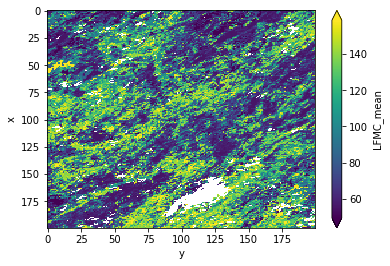

In [16]:
out.LFMC_mean.plot.imshow(robust=True, yincrease=False)

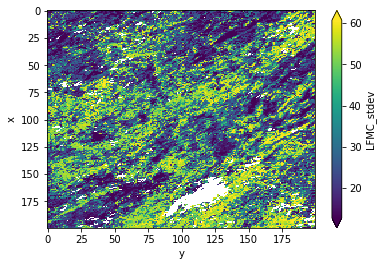

In [17]:
out.LFMC_stdev.plot.imshow(robust=True, yincrease=False)

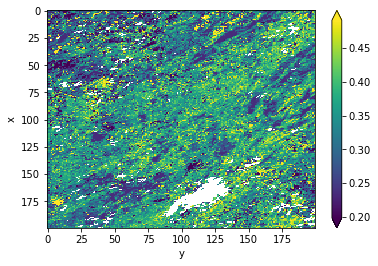

In [18]:
(out.LFMC_stdev / out.LFMC_mean).plot.imshow(robust=True, yincrease=False)

In [20]:
%time out = xr.concat([get_fmc(ds.sel(time=t)) for t in ds.time[:2]], dim='time')
out.to_netcdf('/g/data/xc0/user/HatfieldDodds/LFMC_new_demo_small.nc')

CPU times: user 15min 41s, sys: 10.7 s, total: 15min 52s
Wall time: 15min 37s


In [21]:
d = xr.open_dataset('/g/data/xc0/user/HatfieldDodds/LFMC_new_demo_small.nc')
d

<xarray.Dataset>
Dimensions:     (time: 2, x: 2400, y: 2400)
Coordinates:
  * time        (time) datetime64[ns] 2017-01-01 2017-01-05
Dimensions without coordinates: x, y
Data variables:
    LFMC_mean   (time, x, y) float32 nan nan nan 55.6625 55.6625 55.6625 ...
    LFMC_stdev  (time, x, y) float32 nan nan nan 13.1008 13.1008 13.1008 ...

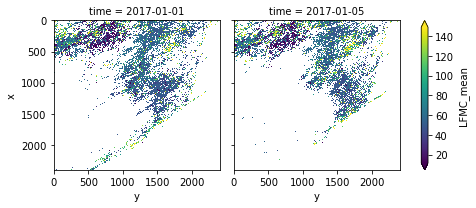

In [22]:
d.LFMC_mean.plot.imshow(robust=True, yincrease=False, col='time')